## Navigation <a class="anchor" id="menu"></a>

#### Day 1

0. [Introduction](#intro)
1. [Import packages](#setup)
2. [Get the data](#data)
3. [Initial attempt at training](#train_first)
4. [Data exploration](#init_edit)
    
     
5. [Feature engineering](#feature_engineering)

6. [Bring everything together](#bring_together)
     
   
7. [Final training](#model)
    - [Polynomial regression](#overfit)
    - [Boosted trees](#final_model)
    - [Random forest](#random_forest)
    - [SVM](#svm)
    - [Neural network](#neural_network)

# Introduction <a class="anchor" id="intro"></a>
[Back to top](#menu)

### Problem at hand
<p> We are going to try to predict weekly grocery expenses of families based on the data we have collected about them over the course of 2 years.</p>


### Data
<p> We have data on: </p>
<ul>
<li> demographic information of families </li>
<li> transactions, per item they bought </li>
<li> details about the products in the grocery store </li>
<li> campaign that were in effect every week </li>
<li> special promotions per each family </li>
</ul>
    
### Method
Our target is the weekly spending amount but the data we have collected is in different formats. Some of them are per week and some of them are per day. So, going forward, we will have to aggregate and alter the data to turn it into the format we wish to have.

Steps:
<li> Importing and exploring the dataset </li>
<li> Doing the necessary changes to the data to have it in the format we need </li>
<li> Extracting more information from the raw data we collected </li>

### Learning outcomes

Through this hands-on session we will learn:
* Best practices
* Common pitfalls to avoid
* Data Science tools and how/when to use them

# 1. Import packages and define functions <a class="anchor" id="setup"></a>
[Back to top](#menu)

In [1]:
# !pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable codefolding/main

In [2]:
# necessary imports and functions
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import random
import pixiedust

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000000)
matplotlib.rcParams.update({'font.size': 20})

def add_month_names(day):
    day_number = day%340
    if day_number<10:
        return 'February', 2
    elif day_number<40:
        return 'March', 3
    elif day_number<70:
        return 'April', 4
    elif day_number<100:
        return 'May', 5
    elif day_number<130:
        return 'June', 6
    elif day_number<160:
        return 'July', 7
    elif day_number<190:
        return 'August', 8
    elif day_number<220:
        return 'September', 9
    elif day_number<250:
        return 'October', 10
    elif day_number<280:
        return 'November', 11
    elif day_number<310:
        return 'December', 12
    elif day_number<340:
        return 'January', 1
    
def add_week_day_names(day):
    day_number = day%7
    if day_number==1:
        return 'Tuesday', day_number+1
    elif day_number==2:
        return 'Wednesday', day_number+1
    elif day_number==3:
        return 'Thursday', day_number+1
    elif day_number==4:
        return 'Friday', day_number+1
    elif day_number==5:
        return 'Saturday', day_number+1
    elif day_number==6:
        return 'Sunday', day_number+1
    elif day_number==0:
        return 'Monday', day_number+1
    
def get_season(month):
    if month == 'December' or month == 'January' or month == 'February':
        return 'winter'
    elif month == 'March' or month == 'April' or month == 'May':
        return 'spring'
    elif month == 'June' or month == 'July' or month == 'August':
        return 'summer'
    elif month == 'September' or month == 'October' or month == 'November':
        return 'fall'
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = [x+1 for x in y_true]
    y_pred = [x+1 for x in y_pred]
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
   
def fill_nas_for_last_day(days_since_shopping):

    new_column = []
    days_since_column = days_since_shopping.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    next_day_since_value = 0
    
    for i in range(0,len(days_since_column)):
        num_weeks = 1
        value = days_since_column[i]
        
        if math.isnan(value):
            a = i+1
            if a<len(days_since_column):
                next_day_since_value = days_since_column[a]

                #get the next since value
                while math.isnan(next_day_since_value) and a<len(days_since_column)-1:
                    a = a+1
#                     print(a)
                    next_day_since_value = days_since_column[a]
                    num_weeks = num_weeks+1

                if next_day_since_value >= 7*num_weeks:
                    value = next_day_since_value-7*num_weeks

            new_column.append(value)
    #             print('number of weeks: ' + str(num_weeks))
    #             print('instead of nan: ' + str(value))
            
        else:
#             print('*****' + str(value))
            new_column.append(value)
    
    return pd.Series(new_column, index=days_since_shopping.index)

def fill_nas_for_spent_trip(amount_spent_last_trip):

    new_column = []
    amount_spent_last_trip_column = amount_spent_last_trip.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(amount_spent_last_trip_column)):
        amount = amount_spent_last_trip_column[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=amount_spent_last_trip.index)

def fill_nas_for_last_week(weeks_since_shopping):

    new_column = []
    weeks_since_column = weeks_since_shopping.tolist()
#     print(weeks_since_column)
#     print(len(weeks_since_column))
    
    next_day_since_value = 0
    
    for i in range(0,len(weeks_since_column)):
        num_weeks = 1
        value = weeks_since_column[i]
        
        if math.isnan(value):
            a = i+1
            if a<len(weeks_since_column):
                next_day_since_value = weeks_since_column[a]

                #get the next since value
                while math.isnan(next_day_since_value) and a<len(weeks_since_column)-1:
                    a = a+1
#                     print(a)
                    next_day_since_value = weeks_since_column[a]
                    num_weeks = num_weeks+1

                if next_day_since_value >= num_weeks:
                    value = next_day_since_value-num_weeks

            new_column.append(value)
    #             print('number of weeks: ' + str(num_weeks))
    #             print('instead of nan: ' + str(value))
            
        else:
#             print('*****' + str(value))
            new_column.append(value)
    
    return pd.Series(new_column, index=weeks_since_shopping.index)

def fill_nas_for_prev_trip(stats_column):

    new_column = []
    stats_column_list = stats_column.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(stats_column_list)):
        amount = stats_column_list[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=stats_column.index)

def fill_nas_for_weighted_avg(weighted_avg):

    new_column = []
    weighted_avg_column = weighted_avg.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(weighted_avg_column)):
        amount = weighted_avg_column[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=weighted_avg.index)

def training_testing_metrics(X_train, y_train, X_test, y_test, model):
    y_pred_train = model.predict(X_train)
    
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = math.sqrt(mse_train)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train) 
    
    preds = model.predict(X_test)
    
    mae_test = mean_absolute_error(y_test, preds)
    mse_test = mean_squared_error(y_test, preds)
    rmse_test = math.sqrt(mse_test)
    mape_test = mean_absolute_percentage_error(y_test, preds)
    r2_test = r2_score(y_test, preds) 
    
    metrics = {'metrics':['mean absolute error','mean squared error','root mean squared error','mean absolute percentage error','r2'],'training': [mae_train,mse_train,rmse_train,mape_train,r2_train], 'testing': [mae_test,mse_test,rmse_test,mape_test,r2_test]}
    return pd.DataFrame(data=metrics)
    

Pixiedust database opened successfully


# 2. Reading data <a class="anchor" id="data"></a>
[Back to top](#menu)

In [3]:

# from ibmdbpy import IdaDataBase, IdaDataFrame

# # @hidden_cell
# # This connection object is used to access your data and contains your credentials.
# # You might want to remove those credentials before you share your notebook.

# idadb_b3e7834f1aa143dab76e6ff65365d57c = IdaDataBase(dsn='DASHDB;Database=BLUDB;Hostname=dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net;Port=50000;PROTOCOL=TCPIP;UID=vzr40997;PWD=v^jpb6cht1d6d3h2')

# df_campaigns = IdaDataFrame(idadb_b3e7834f1aa143dab76e6ff65365d57c, 'VZR40997.CAMPAIGNS').as_dataframe()
# df_demographics = IdaDataFrame(idadb_b3e7834f1aa143dab76e6ff65365d57c, 'VZR40997.DEMOGRAPHICS').as_dataframe()
# df_products = IdaDataFrame(idadb_b3e7834f1aa143dab76e6ff65365d57c, 'VZR40997.PRODUCTS').as_dataframe()
# df_transactions = IdaDataFrame(idadb_b3e7834f1aa143dab76e6ff65365d57c, 'VZR40997.TRANSACTIONS').as_dataframe()
# df_promotions = IdaDataFrame(idadb_b3e7834f1aa143dab76e6ff65365d57c, 'VZR40997.PROMOTIONS').as_dataframe()

# print('Data loading complete!')
# idadb_b3e7834f1aa143dab76e6ff65365d57c.close()


In [4]:
df_transactions = pd.read_csv('data/transactions.csv')
df_demographics = pd.read_csv('data/demographics.csv')
df_products = pd.read_csv('data/products.csv')
df_promotions = pd.read_csv('data_new/promotions.csv')
df_campaigns = pd.read_csv('data/campaigns.csv')

print('Data loading complete!')

Data loading complete!


# 3. Fitting a preliminary model <a class="anchor" id="train_first"></a>
[Back to top](#menu)

<h3> Before fitting a model, we need to aggregate the data to represent weekly behaviour </h3>

In [5]:
transactions_weekly_aggregated = df_transactions.groupby(["HOUSEHOLD_KEY", "WEEK_NO"])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
transactions_weekly_aggregated = transactions_weekly_aggregated.sort_values(by=['HOUSEHOLD_KEY','WEEK_NO']).reset_index().drop('index', axis=1)
# start_df = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
# start_df = start_df.fillna(0)
start_df = transactions_weekly_aggregated.fillna(0)
print(start_df.shape)
start_df.head()


(56488, 5)


,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,8,78.66,34.0,-16.54
1,1,10,41.10,14.0,-8.59
2,1,13,26.90,13.0,-6.72
3,1,14,63.43,32.0,-11.58
4,1,15,53.45,20.0,-16.42


<h3> Merge all the data we have </h3>

In [6]:
# Merge everything together

a = start_df.merge(df_demographics, on='HOUSEHOLD_KEY', how='left')
b = a.merge(df_campaigns, on='WEEK_NO', how='left')
c = b.merge(df_promotions, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

all_data = c.copy()
all_data.head()

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,NUM_COUPONS,TIME_IN_APP,WEEKLY_BONUS_POINTS
0,1,8,78.66,34.0,-16.54,65,2,2,0,1.0,42000,0,-3,0,63.70,NaN
1,1,10,41.10,14.0,-8.59,65,2,2,0,1.0,42000,0,0,0,72.17,NaN
2,1,13,26.90,13.0,-6.72,65,2,2,0,1.0,42000,0,-4,0,77.16,NaN
3,1,14,63.43,32.0,-11.58,65,2,2,0,1.0,42000,0,-4,0,68.56,NaN
4,1,15,53.45,20.0,-16.42,65,2,2,0,1.0,42000,0,0,0,69.86,NaN


<h3> Separate the target variable </h3>

In [7]:
# select columns for training
exclude_columns = ['WEEK_NO','HOUSEHOLD_KEY','year']
training_columns = [x for x in all_data.columns if x not in exclude_columns]
columns_to_predict_on = [x for x in training_columns if x != 'SALES_VALUE']

training_data = all_data[training_columns]
training_data.dropna(inplace=True)

X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print('Amount of all data: ' +str(X.shape[0]))

y = training_data['SALES_VALUE']

Amount of all data: 27129


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [8]:
training_data.shape

(27129, 14)

<h3> Train and test split </h3>

In [9]:
total_data_amount = X.shape[0]
training_amount = int(total_data_amount*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

print('Amount of training data: ' + str(X_train.shape[0]))
print('Amount of test data: ' + str(X_test.shape[0]))

Amount of training data: 21703
Amount of test data: 5426


### Let's train our model

In [10]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", max_depth=10, n_estimators=50)

# xgb_model = xgb.XGBRegressor(objective="reg:squarederror", max_depth=10, n_jobs=3, eval_metric='rmse', eta=0.7, n_estimators=100, subsample=0.5)

xgb_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

### Evaluation metrics

In [11]:
training_testing_metrics(X_train, y_train, X_test, y_test, xgb_model)


,metrics,training,testing
0,mean absolute error,3.604702,5.733712
1,mean squared error,23.908601,101.758842
2,root mean squared error,4.889642,10.087559
3,mean absolute percentage error,8.593330,10.854076
4,r2,0.995652,0.982181


### Looks pretty good! Let's see which feature helps us predict the sales amount this well.

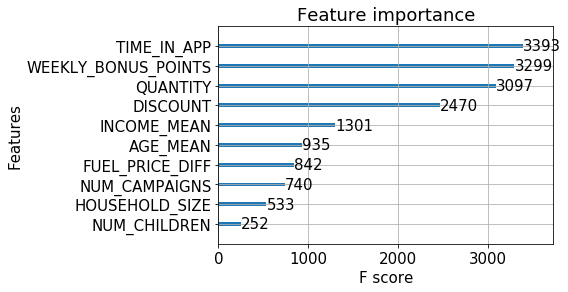

In [12]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(xgb_model,max_num_features=10)

### Oops. We might have made a mistake! 😅 There is a data leakage.
<p> Leakage happens when: </p>
A feature that is highly related to the target feature (and/or is determined by the target feature) is left as a training feature. 
    In this example, we left the feature "QUANTITY" in the training set. The amount people spent on their groceries is highly effected by how many items they bought. And additionally, when one wants to predict the amount to be spent on a shopping trip in the future, one cannot use the Quantity information simply because we don't know that yet. That's why, we have to make sure that we don't include this type of dependent features in our training set.

In [13]:
# fix leakage problem
all_data_after_leakage = all_data.copy()

#1
all_data_after_leakage['QUANTITY'] = all_data_after_leakage.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['QUANTITY'].shift(1)

#2
all_data_after_leakage['DISCOUNT'] = all_data_after_leakage.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['DISCOUNT'].shift(1)

#3
all_data_after_leakage['TIME_IN_APP'] = all_data_after_leakage.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['TIME_IN_APP'].shift(1)


training_data = all_data_after_leakage[training_columns]
training_data.dropna(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


* ### Let's try it again

In [14]:
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

(27448, 13)


In [15]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", max_depth=10, n_estimators=50)

# xgb_model = xgb.XGBRegressor(objective="reg:squarederror", max_depth=10, n_jobs=3, eval_metric='rmse', eta=0.7, n_estimators=100, subsample=0.5)

xgb_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [16]:
training_testing_metrics(X_train, y_train, X_test, y_test, xgb_model)


,metrics,training,testing
0,mean absolute error,30.622326,47.571418
1,mean squared error,1763.257887,4552.889702
2,root mean squared error,41.991164,67.475104
3,mean absolute percentage error,105.275501,131.172160
4,r2,0.678941,0.197465


* ### We have a model to improve!

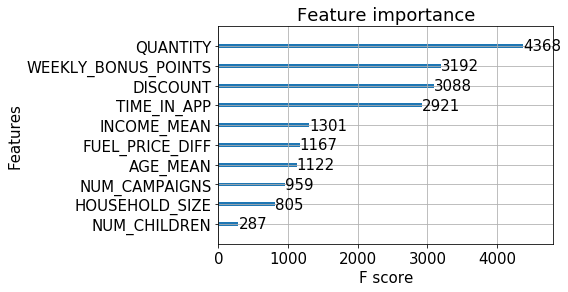

In [17]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(xgb_model,max_num_features=10)

# 4. Data exploration <a class="anchor" id="init_edit"></a>
[Back to top](#menu)

In [18]:
d = {'df_transactions': df_transactions.columns.tolist(), 'df_products': df_products.columns.tolist(),
    'df_campaigns': df_campaigns.columns.tolist(), 'df_promotions': df_promotions.columns.tolist(),
    'df_demographics': df_demographics.columns.tolist()}

all_dfs = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
all_dfs = all_dfs.fillna('')
all_dfs


,df_transactions,df_products,df_campaigns,df_promotions,df_demographics
0,DAY,PRODUCT_ID,WEEK_NO,WEEK_NO,HOUSEHOLD_KEY
1,WEEK_NO,DEPARTMENT,NUM_CAMPAIGNS,HOUSEHOLD_KEY,AGE_MEAN
2,HOUSEHOLD_KEY,COMMODITY_DESC,FUEL_PRICE_DIFF,NUM_COUPONS,HOUSEHOLD_SIZE
3,PRODUCT_ID,,,TIME_IN_APP,NUM_ADULTS
4,SALES_VALUE,,,WEEKLY_BONUS_POINTS,NUM_CHILDREN
5,QUANTITY,,,,MARITAL_STATUS
6,DISCOUNT,,,,INCOME_MEAN


### We can join tables with tables' common columns. For example, we can merge the transactions table with the products table to see the details of a given product, rather than only seeing the 'PRODUCT_ID'

In [19]:
trans_products = df_transactions.merge(df_products, on='PRODUCT_ID', how='left')
trans_products.head()

,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT,DEPARTMENT,COMMODITY_DESC
0,1,1,98,782443249,0.39,1.0,0.00,PRODUCE,TROPICAL FRUIT
1,1,1,98,3112548822,3.00,2.0,-0.08,GROCERY,COOKIES/CONES
2,1,1,98,6571651611,1.15,4.0,0.00,GROCERY,BAG SNACKS
3,1,1,98,8840487053,1.25,1.0,-0.34,GROCERY,BAKED SWEET GOODS
4,1,1,212,782443249,0.65,1.0,0.00,PRODUCE,TROPICAL FRUIT


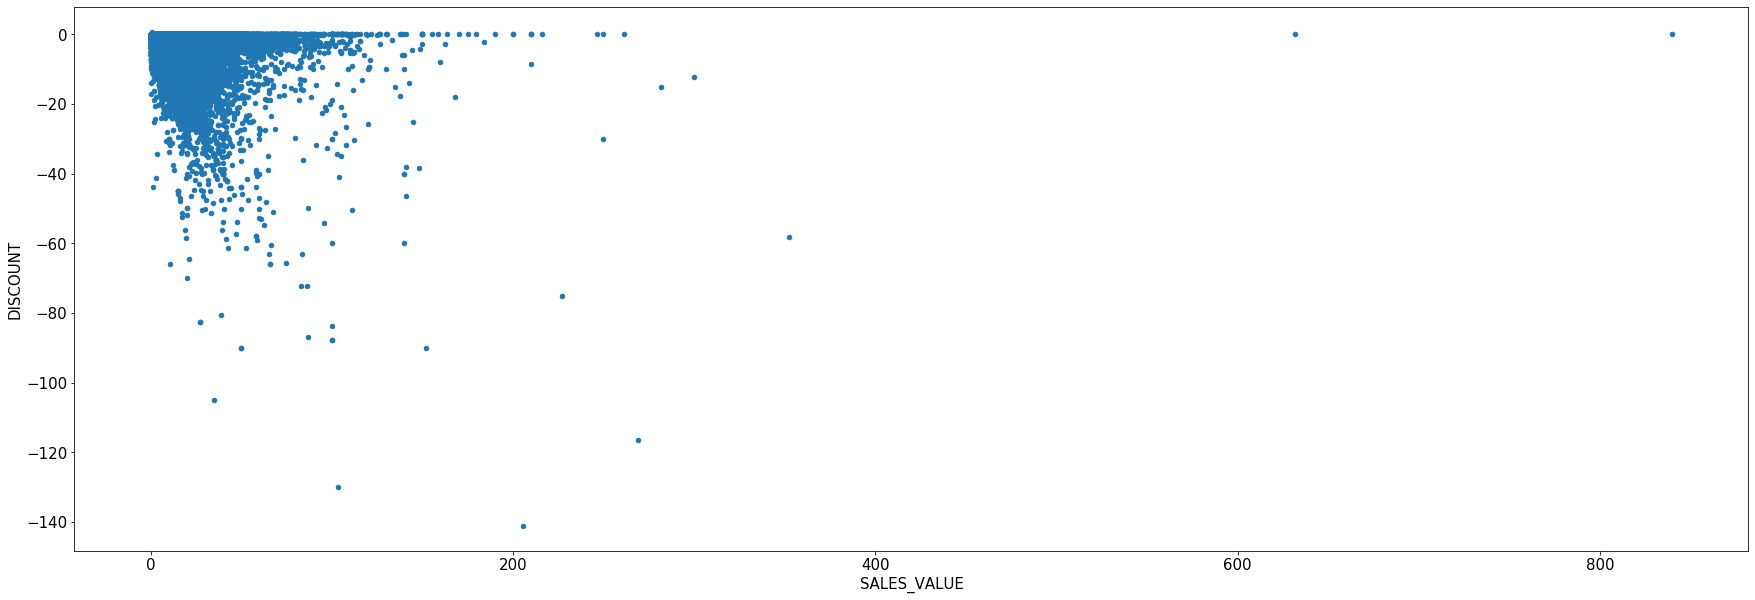

In [20]:
trans_products.plot(x='SALES_VALUE',y='DISCOUNT',figsize=(30,10),kind='scatter')

### You can choose which data frame's values to display. Select one of them and explore the distribution of the values.

In [21]:
print('choose one of them: ' + str(all_dfs.columns.tolist()) + '\nand change the dataframe in the next 2 cells to explore.')


choose one of them: ['df_transactions', 'df_products', 'df_campaigns', 'df_promotions', 'df_demographics']
and change the dataframe in the next 2 cells to explore.


In [22]:
df_transactions.sort_values(['WEEK_NO','HOUSEHOLD_KEY']).head()

,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT
404,5,1,77,3598272088,7.99,1.0,0.00
405,5,1,77,4744896796,7.99,1.0,0.00
406,5,1,77,5591447946,2.71,4.0,-2.75
407,5,1,77,6781602629,3.38,2.0,0.00
0,1,1,98,782443249,0.39,1.0,0.00


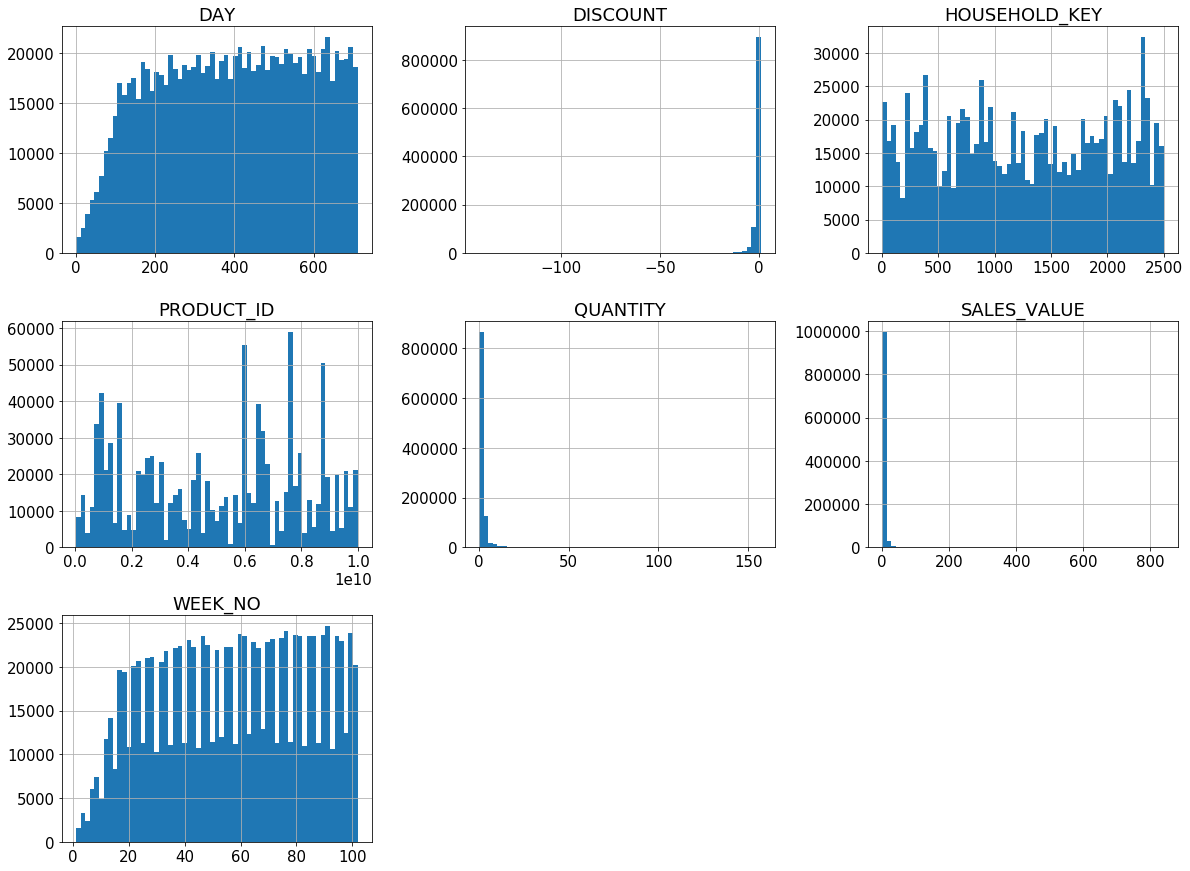

In [23]:
_ = df_transactions.hist(bins=61, figsize=(20,15))

* ### Households are not equally represented in the transactions dataset. So we need a complete table that we can populate with the information from the dataset


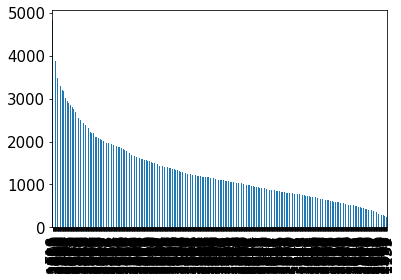

In [24]:
df_transactions['HOUSEHOLD_KEY'].value_counts().plot(kind='bar')


(81702, 2)


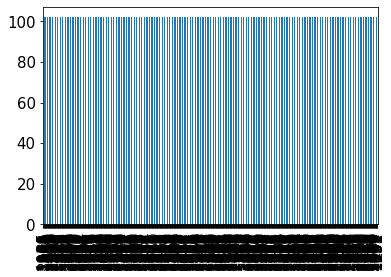

In [25]:

# creating a table that has a row for each week for each household

households = df_transactions['HOUSEHOLD_KEY'].sort_values().unique()
max_week = df_transactions['WEEK_NO'].max()

big_df = pd.DataFrame()

for key in households:
    df = pd.DataFrame()
    df['WEEK_NO'] = np.arange(1,max_week+1)
    df['HOUSEHOLD_KEY'] = key
    
    big_df = pd.concat([big_df,df])

print(big_df.shape)
# big_df.head()

big_df['HOUSEHOLD_KEY'].value_counts().plot(kind='bar')


# 5. Feature Engineering <a class="anchor" id="feature_engineering"></a>
[jump to end of this part](#bring_together)
[Back to top](#menu)

### 5.1. Time information
"DAY" goes from 1 to 700. Can we get more info on the time of the transaction? E.g. season, month

In [26]:
df_transactions.head()

,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT
0,1,1,98,782443249,0.39,1.0,0.00
1,1,1,98,3112548822,3.00,2.0,-0.08
2,1,1,98,6571651611,1.15,4.0,0.00
3,1,1,98,8840487053,1.25,1.0,-0.34
4,1,1,212,782443249,0.65,1.0,0.00


Looking into the products that people buy is one option

In [27]:
df_products.head()

,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC
0,3878731104,AUTOMOTIVE,COUPON
1,5617044735,AUTOMOTIVE,NEWSPAPER
2,3333525418,CHARITABLE CONT,UNKNOWN
3,5678132014,CHEF SHOPPE,UNKNOWN
4,6163551664,CNTRL/STORE SUP,COUPON/MISC ITEMS


In [28]:
sorted(df_products['COMMODITY_DESC'].unique())

['(CORP USE ONLY)',
 'ADULT INCONTINENCE',
 'AIR CARE',
 'ANALGESICS',
 'ANTACIDS',
 'APPAREL',
 'APPLES',
 'AUDIO/VIDEO PRODUCTS',
 'AUTOMOTIVE PRODUCTS',
 'BABY FOODS',
 'BABY HBC',
 'BABYFOOD',
 'BACON',
 'BAG SNACKS',
 'BAKED BREAD/BUNS/ROLLS',
 'BAKED SWEET GOODS',
 'BAKERY PARTY TRAYS',
 'BAKING',
 'BAKING MIXES',
 'BAKING NEEDS',
 'BATH',
 'BATH TISSUES',
 'BATTERIES',
 'BEANS - CANNED GLASS & MW',
 'BEEF',
 'BEERS/ALES',
 'BERRIES',
 'BEVERAGE',
 'BIRD SEED',
 'BLEACH',
 'BOOKSTORE',
 'BOTTLE DEPOSITS',
 'BOUQUET (NON ROSE)',
 'BREAD',
 'BREAKFAST SAUSAGE/SANDWICHES',
 'BREAKFAST SWEETS',
 'BROCCOLI/CAULIFLOWER',
 'BROOMS AND MOPS',
 'BULK FOODS',
 'BUTTER',
 'CAKES',
 'CANDLES/ACCESSORIES',
 'CANDY - CHECKLANE',
 'CANDY - PACKAGED',
 'CANNED JUICES',
 'CANNED MILK',
 'CARROTS',
 'CAT FOOD',
 'CAT LITTER',
 'CEREAL/BREAKFAST',
 'CHARCOAL AND LIGHTER FLUID',
 'CHEESE',
 'CHEESES',
 'CHICKEN',
 'CHICKEN/POULTRY',
 'CHIPS&SNACKS',
 'CHRISTMAS  SEASONAL',
 'CIGARETTES',
 'CIGARS',


### Aha! 💡There is something called "CHRISTMAS SEASONAL"
Let's search for other seasonal product descriptions

In [29]:
df_products[df_products['COMMODITY_DESC'].str.contains('SEASONAL')]['COMMODITY_DESC'].drop_duplicates()


42          CHRISTMAS  SEASONAL
60     FALL AND WINTER SEASONAL
109      SPRING/SUMMER SEASONAL
326                    SEASONAL
Name: COMMODITY_DESC, dtype: object

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  if __name__ == '__main__':


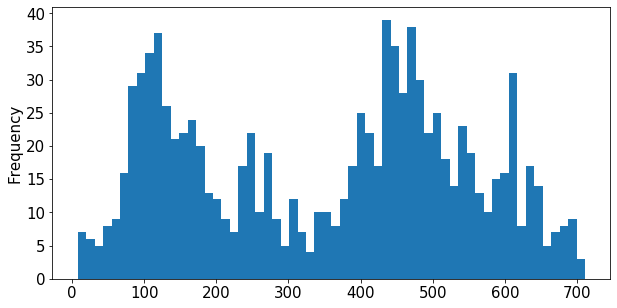

In [30]:
spring_summer_products = df_products[df_products['COMMODITY_DESC']=='SPRING/SUMMER SEASONAL']['PRODUCT_ID'].to_list()
fall_winter_products = df_products[df_products['COMMODITY_DESC']=='FALL AND WINTER SEASONAL']['PRODUCT_ID'].to_list()
christmas_products = df_products[df_products['COMMODITY_DESC'].str.contains('CHRISTMAS')]['PRODUCT_ID'].to_list()

spring_summer = df_transactions[df_transactions['PRODUCT_ID'].isin(spring_summer_products)]
fall_winter = df_transactions[df_transactions['PRODUCT_ID'].isin(fall_winter_products)]
christmas = df_transactions[df_transactions['PRODUCT_ID'].isin(christmas_products)]

spring_summer['DAY'].plot('hist', bins=60, figsize=(10,5))

### This gives us a good idea about when spring is and thus we can take a good guess on which month it is.

### Additionally, checking when the week number increments, we can find out more about which day of the week a certain transaction takes place.

In [31]:
df_transactions['month'], df_transactions['month_num'] = zip(*df_transactions['DAY'].apply(add_month_names))
df_transactions['weekday'],df_transactions['weekday_num'] = zip(*df_transactions['DAY'].apply(add_week_day_names))
df_transactions['season'] = df_transactions['month'].apply(get_season)
df_transactions.head()

,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT,month,month_num,weekday,weekday_num,season
0,1,1,98,782443249,0.39,1.0,0.00,February,2,Tuesday,2,winter
1,1,1,98,3112548822,3.00,2.0,-0.08,February,2,Tuesday,2,winter
2,1,1,98,6571651611,1.15,4.0,0.00,February,2,Tuesday,2,winter
3,1,1,98,8840487053,1.25,1.0,-0.34,February,2,Tuesday,2,winter
4,1,1,212,782443249,0.65,1.0,0.00,February,2,Tuesday,2,winter


Let's prepare a lookup table where we can find the month and season given a week number

In [32]:
week_month_lookup = df_transactions[['DAY','WEEK_NO','month_num']].drop_duplicates().reset_index().drop('index',axis=1)
week_month_lookup.drop('DAY', axis=1, inplace=True)
week_month_lookup.drop_duplicates(subset=['WEEK_NO'], keep="first", inplace=True)
# note: if a week starts at a month and ends in a different month, we assign it to the month it started in

week_month_season_lookup = week_month_lookup.merge(df_transactions[['WEEK_NO','month_num','month','season']].drop_duplicates(), on=['WEEK_NO','month_num'], how='left')
week_month_season_lookup['year'] = week_month_season_lookup['WEEK_NO'].apply(lambda x: 2018 if x>45 and x<=93 else (2017 if x<=45 else 2019))
print(week_month_season_lookup.shape)
week_month_season_lookup.head(200)


(102, 5)


,WEEK_NO,month_num,month,season,year
0,1,2,February,winter,2017
1,2,2,February,winter,2017
2,3,3,March,spring,2017
3,4,3,March,spring,2017
4,5,3,March,spring,2017
5,6,3,March,spring,2017
6,7,4,April,spring,2017
7,8,4,April,spring,2017
8,9,4,April,spring,2017
9,10,4,April,spring,2017


### 5.2. days since last shopping for every week

In [33]:
daily_transactions = df_transactions.groupby(["HOUSEHOLD_KEY", "DAY",'WEEK_NO'])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
daily_transactions['last_shopping_day'] = daily_transactions.groupby('HOUSEHOLD_KEY')['DAY'].shift(1)
daily_transactions['days_since_shopping'] = daily_transactions['DAY']-daily_transactions['last_shopping_day']
daily_transactions = daily_transactions[['HOUSEHOLD_KEY','DAY','WEEK_NO','days_since_shopping']]

previous_visit_day = daily_transactions.groupby(['HOUSEHOLD_KEY','WEEK_NO']).mean().reset_index()
previous_visit_day.drop('DAY', axis=1, inplace=True)

a = big_df.merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
a['days_since_last_shopping'] = a.groupby('HOUSEHOLD_KEY')['days_since_shopping'].apply(fill_nas_for_last_day)

previous_visit_day = a[['HOUSEHOLD_KEY', 'WEEK_NO', 'days_since_last_shopping']].copy()
print(previous_visit_day.shape)
previous_visit_day.head(10)


(81702, 3)


,HOUSEHOLD_KEY,WEEK_NO,days_since_last_shopping
0,1,1,NaN
1,1,2,NaN
2,1,3,NaN
3,1,4,NaN
4,1,5,NaN
5,1,6,NaN
6,1,7,NaN
7,1,8,2.0
8,1,9,9.0
9,1,10,16.0


### 5.3. Amount spent on last shopping trip

In [34]:
spent_last_trip_df = transactions_weekly_aggregated.copy()
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df['SALES_VALUE']#.shift(1)
spent_last_trip_df = big_df.merge(spent_last_trip_df[['HOUSEHOLD_KEY','WEEK_NO','amount_spent_last_trip']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df.groupby('HOUSEHOLD_KEY')['amount_spent_last_trip'].apply(fill_nas_for_spent_trip)
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df['amount_spent_last_trip'].shift(1)
spent_last_trip_df.head(10)


,WEEK_NO,HOUSEHOLD_KEY,amount_spent_last_trip
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN
5,6,1,NaN
6,7,1,NaN
7,8,1,NaN
8,9,1,78.66
9,10,1,78.66


### 5.4. Amount spent last week

In [35]:
spent_last_week_df = transactions_weekly_aggregated.copy()
spent_last_week_df = big_df.merge(spent_last_week_df[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
spent_last_week_df['amount_spent_last_week'] = spent_last_week_df['SALES_VALUE'].shift(1)
spent_last_week_df['amount_spent_last_week'].fillna(0, inplace=True)
spent_last_week_df = spent_last_week_df[['WEEK_NO','HOUSEHOLD_KEY','amount_spent_last_week']]
spent_last_week_df.head(10)

,WEEK_NO,HOUSEHOLD_KEY,amount_spent_last_week
0,1,1,0.00
1,2,1,0.00
2,3,1,0.00
3,4,1,0.00
4,5,1,0.00
5,6,1,0.00
6,7,1,0.00
7,8,1,0.00
8,9,1,78.66
9,10,1,0.00


### 5.5. Number of weeks since last shopping

In [36]:
num_weeks_since_last_visit = transactions_weekly_aggregated.copy()
num_weeks_since_last_visit['last_shopping_week'] = num_weeks_since_last_visit.groupby('HOUSEHOLD_KEY')['WEEK_NO'].shift(1)
num_weeks_since_last_visit['weeks_since_last_shopping'] = num_weeks_since_last_visit['WEEK_NO']-num_weeks_since_last_visit['last_shopping_week']

num_weeks_since_last_visit = num_weeks_since_last_visit[['HOUSEHOLD_KEY','WEEK_NO','weeks_since_last_shopping']]

num_weeks_since_last_visit = big_df.merge(num_weeks_since_last_visit, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

num_weeks_since_last_visit['weeks_since_last_shopping'] = num_weeks_since_last_visit.groupby('HOUSEHOLD_KEY')['weeks_since_last_shopping'].apply(fill_nas_for_last_week)

num_weeks_since_last_visit.head(10)

,WEEK_NO,HOUSEHOLD_KEY,weeks_since_last_shopping
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN
5,6,1,NaN
6,7,1,NaN
7,8,1,0.0
8,9,1,1.0
9,10,1,2.0


### 5.6. average spent on previous shopping trips (with stats)

In [37]:
# calculate stats 
transactions_with_time = transactions_weekly_aggregated.copy()

mean = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
mean = mean.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().mean()
mean = mean.drop('HOUSEHOLD_KEY', axis=1).reset_index()
mean.index = mean['level_1']

mean = mean.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
mean = mean.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
mean['avg_spending_previous_trips'] = mean.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
mean = mean.drop('SALES_VALUE', axis=1)
# print(mean.shape)
# mean.head(100)

std = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
std = std.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().std()
std = std.drop('HOUSEHOLD_KEY', axis=1).reset_index()
std.index = std['level_1']

std = std.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
std = std.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
std['std_spending_previous_trips'] = std.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
std = std.drop('SALES_VALUE', axis=1)
# print(std.shape)
# std.head(100)

var = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
var = var.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().var()
var = var.drop('HOUSEHOLD_KEY', axis=1).reset_index()
var.index = var['level_1']

var = var.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
var = var.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
var['var_spending_previous_trips'] = var.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
var = var.drop('SALES_VALUE', axis=1)
# print(var.shape)
# var.head(100)

quan25 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan25 = quan25.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.25)
quan25 = quan25.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan25.index = quan25['level_1']

quan25 = quan25.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan25 = quan25.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan25['quan25_spending_previous_trips'] = quan25.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan25 = quan25.drop('SALES_VALUE', axis=1)
# print(quan25.shape)
# quan25.head(100)

quan50 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan50 = quan50.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.5)
quan50 = quan50.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan50.index = quan50['level_1']

quan50 = quan50.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan50 = quan50.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan50['quan50_spending_previous_trips'] = quan50.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan50 = quan50.drop('SALES_VALUE', axis=1)
# print(quan50.shape)
# quan50.head(100)

quan75 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan75 = quan75.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.75)
quan75 = quan75.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan75.index = quan75['level_1']

quan75 = quan75.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan75 = quan75.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan75['quan75_spending_previous_trips'] = quan75.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan75 = quan75.drop('SALES_VALUE', axis=1)
# print(quan75.shape)
# quan75.head(100)

stats_prev_trips = big_df.merge(mean, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(std, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(var, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan25, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan50, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan75, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

for column in stats_prev_trips:
    if column != 'WEEK_NO' or column != 'HOUSEHOLD_KEY':
        stats_prev_trips[column] = stats_prev_trips.groupby('HOUSEHOLD_KEY')[column].apply(fill_nas_for_prev_trip)

stats_prev_trips.head()


,WEEK_NO,HOUSEHOLD_KEY,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN


### 5.7. average spent on previous weeks (with stats)

In [38]:
# calculate stats 
transactions_every_week = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

mean_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
mean_r = mean_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().mean()
mean_r = mean_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
mean_r.index = mean_r['level_1']

mean_r = mean_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
mean_r = mean_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
mean_r['avg_spending_previous_weeks_real_time'] = mean_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
mean_r = mean_r.drop('SALES_VALUE', axis=1)
# print(mean_r.shape)
# mean_r.head(10)


std_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
std_r = std_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().std()
std_r = std_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
std_r.index = std_r['level_1']

std_r = std_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
std_r = std_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
std_r['std_spending_previous_weeks_real_time'] = std_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
std_r = std_r.drop('SALES_VALUE', axis=1)
# print(std_r.shape)
# std_r.head()


var_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
var_r = var_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().var()
var_r = var_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
var_r.index = var_r['level_1']

var_r = var_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
var_r = var_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
var_r['var_spending_previous_weeks_real_time'] = var_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
var_r = var_r.drop('SALES_VALUE', axis=1)
# print(var_r.shape)
# var_r.head(10)


quan25_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan25_r = quan25_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.25)
quan25_r = quan25_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan25_r.index = quan25_r['level_1']

quan25_r = quan25_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan25_r = quan25_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan25_r['quan25_spending_previous_weeks_real_time'] = quan25_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan25_r = quan25_r.drop('SALES_VALUE', axis=1)
# print(quan25_r.shape)
# quan25_r.head(10)


quan50_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan50_r = quan50_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.5)
quan50_r = quan50_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan50_r.index = quan50_r['level_1']

quan50_r = quan50_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan50_r = quan50_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan50_r['quan50_spending_previous_weeks_real_time'] = quan50_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan50_r = quan50_r.drop('SALES_VALUE', axis=1)
# print(quan50_r.shape)
# quan50_r.head(10)


quan75_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan75_r = quan75_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.75)
quan75_r = quan75_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan75_r.index = quan75_r['level_1']

quan75_r = quan75_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan75_r = quan75_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan75_r['quan75_spending_previous_weeks_real_time'] = quan75_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan75_r = quan75_r.drop('SALES_VALUE', axis=1)
# print(quan75_r.shape)
# quan75_r.head(10)

stats_prev_weeks = big_df.merge(mean_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(std_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(var_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan25_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan50_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan75_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

print(stats_prev_weeks.shape)
stats_prev_weeks.head(10)


(81702, 8)


,WEEK_NO,HOUSEHOLD_KEY,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN
5,6,1,NaN,NaN,NaN,NaN,NaN,NaN
6,7,1,NaN,NaN,NaN,NaN,NaN,NaN
7,8,1,NaN,NaN,NaN,NaN,NaN,NaN
8,9,1,78.66,NaN,NaN,78.66,78.66,78.66
9,10,1,78.66,NaN,NaN,78.66,78.66,78.66


### 5.8. weighted mean of last 10 trips' spendings

In [39]:
weighted_avg_trips = transactions_weekly_aggregated.copy()
weighted_avg_trips['1_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
weighted_avg_trips['2_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(2)
weighted_avg_trips['3_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(3)
weighted_avg_trips['4_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(4)
weighted_avg_trips['5_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(5)
weighted_avg_trips['6_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(6)
weighted_avg_trips['7_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(7)
weighted_avg_trips['8_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(8)
weighted_avg_trips['9_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(9)
weighted_avg_trips['10_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(10)

weighted_avg_trips['weighted_avg_trips'] = (weighted_avg_trips['1_times_before']*10 + 
                               weighted_avg_trips['2_times_before']*9 +
                               weighted_avg_trips['3_times_before']*8 +
                               weighted_avg_trips['4_times_before']*7 +
                               weighted_avg_trips['5_times_before']*6 +
                               weighted_avg_trips['6_times_before']*5 +
                               weighted_avg_trips['7_times_before']*4 +
                               weighted_avg_trips['8_times_before']*3 +
                               weighted_avg_trips['9_times_before']*2 +
                               weighted_avg_trips['10_times_before']*1)/(1+2+3+4+5+6+7+8+9+10)

weighted_avg_trips = weighted_avg_trips[['HOUSEHOLD_KEY','WEEK_NO','weighted_avg_trips']]

weighted_avg_trips = big_df.merge(weighted_avg_trips[['HOUSEHOLD_KEY','WEEK_NO','weighted_avg_trips']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

weighted_avg_trips['weighted_avg_trips'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['weighted_avg_trips'].apply(fill_nas_for_weighted_avg)
weighted_avg_trips.head(10)




,WEEK_NO,HOUSEHOLD_KEY,weighted_avg_trips
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN
5,6,1,NaN
6,7,1,NaN
7,8,1,NaN
8,9,1,NaN
9,10,1,NaN


### 5.9. weighted mean of last 10 weeks' spendings

In [40]:
transactions_every_week = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

weighted_avg_weeks = transactions_every_week.copy()
weighted_avg_weeks['1_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
weighted_avg_weeks['2_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(2)
weighted_avg_weeks['3_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(3)
weighted_avg_weeks['4_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(4)
weighted_avg_weeks['5_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(5)
weighted_avg_weeks['6_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(6)
weighted_avg_weeks['7_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(7)
weighted_avg_weeks['8_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(8)
weighted_avg_weeks['9_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(9)
weighted_avg_weeks['10_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(10)

weighted_avg_weeks.fillna(0,inplace=True)

weighted_avg_weeks['weighted_avg_weeks'] = (weighted_avg_weeks['1_times_before']*10 + 
                               weighted_avg_weeks['2_times_before']*9 +
                               weighted_avg_weeks['3_times_before']*8 +
                               weighted_avg_weeks['4_times_before']*7 +
                               weighted_avg_weeks['5_times_before']*6 +
                               weighted_avg_weeks['6_times_before']*5 +
                               weighted_avg_weeks['7_times_before']*4 +
                               weighted_avg_weeks['8_times_before']*3 +
                               weighted_avg_weeks['9_times_before']*2 +
                               weighted_avg_weeks['9_times_before']*1)/(1+2+3+4+5+6+7+8+9+10)



weighted_avg_weeks = weighted_avg_weeks[['HOUSEHOLD_KEY','WEEK_NO','weighted_avg_weeks']]
weighted_avg_weeks.head(100)


,HOUSEHOLD_KEY,WEEK_NO,weighted_avg_weeks
0,1,1,0.000000
1,1,2,0.000000
2,1,3,0.000000
3,1,4,0.000000
4,1,5,0.000000
5,1,6,0.000000
6,1,7,0.000000
7,1,8,0.000000
8,1,9,14.301818
9,1,10,12.871636


### 5.10. average visits per week

In [41]:
family_weekly_visits = df_transactions[['HOUSEHOLD_KEY','DAY','WEEK_NO']].drop_duplicates()
family_weekly_visits = family_weekly_visits.groupby(['HOUSEHOLD_KEY','WEEK_NO']).size().reset_index()
family_weekly_visits.rename(columns={0:'week_visit_count'}, inplace=True)
week_visit_count = family_weekly_visits.copy()

expanded_weekly_visit_count = big_df.merge(week_visit_count, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').fillna(0)

rolling_avg_weekly_visit = expanded_weekly_visit_count.sort_values('WEEK_NO').copy()

rolling_avg_weekly_visit = pd.DataFrame(rolling_avg_weekly_visit.groupby('HOUSEHOLD_KEY')['week_visit_count'].expanding().mean())
rolling_avg_weekly_visit = rolling_avg_weekly_visit.reset_index()
rolling_avg_weekly_visit.drop('level_1', axis=1, inplace=True)

week_col = [[i for i in range(1,103)]]*801
week_col = [i for sublist in week_col for i in sublist]
print(len(week_col))

rolling_avg_weekly_visit['WEEK_NO'] = week_col

average_from_past_weeks = rolling_avg_weekly_visit.copy()

average_from_past_weeks['avg_visits_per_week'] = average_from_past_weeks.groupby('HOUSEHOLD_KEY')['week_visit_count'].shift(1)
average_from_past_weeks.drop('week_visit_count', axis=1, inplace=True)

print(average_from_past_weeks.shape)
average_from_past_weeks.head()


81702
(81702, 3)


,HOUSEHOLD_KEY,WEEK_NO,avg_visits_per_week
0,1,1,NaN
1,1,2,0.0
2,1,3,0.0
3,1,4,0.0
4,1,5,0.0


### 5.11. average visits per month

In [42]:
weekly_visit_count = rolling_avg_weekly_visit.copy()
weekly_visit_count['year'] = weekly_visit_count['WEEK_NO'].apply(lambda x: 2018 if x>45 and x<=93 else (2017 if x<=45 else 2019))

weekly_visit_count = weekly_visit_count.merge(week_month_lookup, on=['WEEK_NO'], how='left')

monthly_visit_count = weekly_visit_count.drop('WEEK_NO', axis=1)
monthly_visit_count = pd.DataFrame(monthly_visit_count.groupby(['HOUSEHOLD_KEY','month_num','year'])['week_visit_count'].sum())
monthly_visit_count = monthly_visit_count.reset_index()
monthly_visit_count.rename(columns={'week_visit_count':'month_visit_count'}, inplace=True)
monthly_visit_count = monthly_visit_count.sort_values(['HOUSEHOLD_KEY','year','month_num'], ascending=True).reset_index().drop('index', axis=1)
month_year_table = monthly_visit_count[['year','month_num']]

rolling_avg_monthly_visits = monthly_visit_count.copy()
rolling_avg_monthly_visits = pd.DataFrame(rolling_avg_monthly_visits.groupby('HOUSEHOLD_KEY')['month_visit_count'].expanding().mean())
rolling_avg_monthly_visits = rolling_avg_monthly_visits.reset_index()
rolling_avg_monthly_visits.drop('level_1', axis=1, inplace=True)
rolling_avg_monthly_visits = rolling_avg_monthly_visits.join(month_year_table)

average_from_past_months = rolling_avg_monthly_visits.copy()
average_from_past_months['avg_visits_per_month'] = average_from_past_months.groupby('HOUSEHOLD_KEY')['month_visit_count'].shift(1)
average_from_past_months.drop('month_visit_count', axis=1, inplace=True)

print(average_from_past_months.shape)
average_from_past_months.head()


(20826, 4)


,HOUSEHOLD_KEY,year,month_num,avg_visits_per_month
0,1,2017,2,NaN
1,1,2017,3,0.000000
2,1,2017,4,0.000000
3,1,2017,5,0.205976
4,1,2017,6,0.408603


### 5.12. proportion of shopping weekdays

In [43]:
all_hhs = df_transactions['HOUSEHOLD_KEY'].sort_values().drop_duplicates().tolist()
household_column = [[hh]*7*102 for hh in all_hhs]
household_column = [h for sub in household_column for h in sub]

week_col = [[[i]*7 for i in range(1,103)]]*801
week_col = [i for sublist in week_col for i in sublist]
week_col = [i for sublist in week_col for i in sublist]
weekday_column = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']*102*801
all_weeks_households_weekdays = pd.DataFrame(list(zip(household_column,week_col,weekday_column)), columns=['HOUSEHOLD_KEY','WEEK_NO','weekday'])

shopping_days = df_transactions[['HOUSEHOLD_KEY','WEEK_NO','weekday']].drop_duplicates()

shopping_days = shopping_days.sort_values(['HOUSEHOLD_KEY','WEEK_NO'])
shopping_days['exists'] = 1

all_weeks_households_weekdays_count = all_weeks_households_weekdays.merge(shopping_days, on=['HOUSEHOLD_KEY','WEEK_NO','weekday'], how='left')
all_weeks_households_weekdays_count.fillna(0, inplace=True)

print(all_weeks_households_weekdays_count.shape)
all_weeks_households_weekdays_count.head()

grouped_shopping_day_proportions = all_weeks_households_weekdays_count.groupby('HOUSEHOLD_KEY')

new_df = pd.DataFrame()
for name, group in grouped_shopping_day_proportions:
#     print(group)
    hh_key = group['HOUSEHOLD_KEY'].iloc[0]
    
    weekdays = group[['WEEK_NO','weekday','exists']]
    
    week_col = [[i for i in range(1,103)]]*7
    week_col = [i for sublist in week_col for i in sublist]
    
    hh_col = [[hh_key]*102*7]
    hh_col = [h for sub in hh_col for h in sub]
    
    weekdays = weekdays.groupby('weekday').expanding().sum().reset_index()
    
    weekdays['WEEK_NO'] = week_col
    weekdays['HOUSEHOLD_KEY'] = hh_col
    weekdays.drop('level_1', axis=1, inplace=True)
    
    new_df = new_df.append(weekdays)   
      
shopping_day_proportions = new_df.copy()

visit_day_counts = pd.pivot_table(shopping_day_proportions, columns = 'weekday', values='exists', index=['HOUSEHOLD_KEY','WEEK_NO'] )

visit_day_proportions = visit_day_counts.copy()
visit_day_proportions['total_visits'] =  visit_day_proportions[['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].sum(axis=1)
visit_day_proportions = visit_day_proportions[['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].div(visit_day_proportions['total_visits'], axis=0)
visit_day_proportions.columns = [str(col) + ' %' for col in visit_day_proportions.columns]
visit_day_proportions = visit_day_proportions.reset_index()
visit_day_proportions.fillna(0, inplace=True)

print(visit_day_proportions.shape)
visit_day_proportions.head(10)


(571914, 4)
(81702, 9)


,HOUSEHOLD_KEY,WEEK_NO,Monday %,Tuesday %,Wednesday %,Thursday %,Friday %,Saturday %,Sunday %
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,8,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1,9,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,1,10,0.0,0.0,0.5,0.0,0.5,0.0,0.0


### 5.12. Let's take a closer look at the product dataset

In [44]:
df_products.head()

,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC
0,3878731104,AUTOMOTIVE,COUPON
1,5617044735,AUTOMOTIVE,NEWSPAPER
2,3333525418,CHARITABLE CONT,UNKNOWN
3,5678132014,CHEF SHOPPE,UNKNOWN
4,6163551664,CNTRL/STORE SUP,COUPON/MISC ITEMS


<p> Because the table we will use for training does not include product details, we <b>cannot</b> use the product table directly. </p> 

<p>Maybe we can find commonly bought products and visited departments in order to see which families bought which product how often. This can be valuable information for our prediction!</p>

In [45]:
# Tables that shows us the most popular departments and products
# how many times a family bought from them, normalised

things_families_buy = df_transactions[['HOUSEHOLD_KEY','PRODUCT_ID']].merge(df_products, on='PRODUCT_ID', how='left')
things_families_buy = things_families_buy[['HOUSEHOLD_KEY','DEPARTMENT','COMMODITY_DESC']]
things_families_buy.sort_values(by='HOUSEHOLD_KEY').head()

# finding most popular department
most_popular_department = things_families_buy.drop('HOUSEHOLD_KEY', axis=1).reset_index().drop('index',axis=1)
most_popular_department = most_popular_department.groupby('DEPARTMENT').size().reset_index()
most_popular_department.rename(columns={0:'count'}, inplace=True)
most_popular_department = most_popular_department.sort_values('count', ascending=False)
most_popular_department_list = most_popular_department.head()['DEPARTMENT'].tolist()
most_popular_department_per_family = things_families_buy.groupby(['HOUSEHOLD_KEY','DEPARTMENT']).size().reset_index()
most_popular_department_per_family.rename(columns={0:'count'}, inplace=True)
most_popular_department_per_family_reduced = most_popular_department_per_family[most_popular_department_per_family['DEPARTMENT'].isin(most_popular_department_list)]
popular_department_table = most_popular_department_per_family_reduced.pivot(index='HOUSEHOLD_KEY', columns = 'DEPARTMENT', values='count')
popular_department_table.columns.name = None
popular_department_table.fillna(0, inplace=True)
popular_department_table = popular_department_table.reset_index()

x = popular_department_table.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
values = pd.DataFrame(x_scaled)
values.columns = popular_department_table.columns
values['HOUSEHOLD_KEY'] = popular_department_table['HOUSEHOLD_KEY']
popular_department_table = values.copy()

# finding most popular products
most_popular_commodity = things_families_buy.drop('HOUSEHOLD_KEY', axis=1).reset_index().drop('index',axis=1)
most_popular_commodity = most_popular_commodity.groupby('COMMODITY_DESC').size().reset_index()
most_popular_commodity.rename(columns={0:'count'}, inplace=True)
most_popular_commodity = most_popular_commodity.sort_values('count', ascending=False)
most_popular_commodity_list = most_popular_commodity.head()['COMMODITY_DESC'].tolist()
most_popular_commodity_per_family = things_families_buy.groupby(['HOUSEHOLD_KEY','COMMODITY_DESC']).size().reset_index()
most_popular_commodity_per_family.rename(columns={0:'count'}, inplace=True)
most_popular_commodity_per_family_reduced = most_popular_commodity_per_family[most_popular_commodity_per_family['COMMODITY_DESC'].isin(most_popular_commodity_list)]
popular_commodity_table = most_popular_commodity_per_family_reduced.pivot(index='HOUSEHOLD_KEY', columns = 'COMMODITY_DESC', values='count')
popular_commodity_table.columns.name = None
popular_commodity_table.fillna(0, inplace=True)
popular_commodity_table = popular_commodity_table.reset_index()

x = popular_commodity_table.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
values = pd.DataFrame(x_scaled)
values.columns = popular_commodity_table.columns
values['HOUSEHOLD_KEY'] = popular_commodity_table['HOUSEHOLD_KEY']
popular_commodity_table = values.copy()

print(popular_department_table.head())
popular_commodity_table.head()


   HOUSEHOLD_KEY   DRUG GM   GROCERY      MEAT  MEAT-PCKGD   PRODUCE
0              1  0.141615  0.270451  0.016949    0.352713  0.147233
1              7  0.135404  0.169252  0.148305    0.089147  0.112648
2              8  0.176398  0.266220  0.220339    0.248062  0.142292
3             13  0.352795  0.342031  0.004237    0.286822  0.104743
4             16  0.031056  0.075458  0.063559    0.065891  0.038538


,HOUSEHOLD_KEY,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS
0,1,0.231183,0.322751,0.253333,0.229885,0.090062
1,7,0.096774,0.142857,0.153333,0.132184,0.037267
2,8,0.096774,0.232804,0.280000,0.241379,0.090062
3,13,0.166667,0.185185,0.286667,0.586207,0.102484
4,16,0.053763,0.359788,0.033333,0.258621,0.015528


# 6. Bring everything together <a class="anchor" id="bring_together"></a>
[Back to top](#menu)

In [46]:
transactions_weekly_aggregated = df_transactions.groupby(["HOUSEHOLD_KEY", "WEEK_NO"])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
transactions_weekly_aggregated = transactions_weekly_aggregated.sort_values(by=['HOUSEHOLD_KEY','WEEK_NO']).reset_index().drop('index', axis=1)
start_df = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
start_df = start_df.fillna(0)
start_df.head()

all_data = start_df.merge(week_month_season_lookup, on='WEEK_NO', how='left').merge(popular_department_table, on='HOUSEHOLD_KEY', how='left').merge(popular_commodity_table, on='HOUSEHOLD_KEY', how='left').merge(df_demographics, on='HOUSEHOLD_KEY', how='left').merge(df_campaigns, on='WEEK_NO', how='left').merge(df_promotions, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(spent_last_trip_df, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(spent_last_week_df, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(num_weeks_since_last_visit, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(stats_prev_trips, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(stats_prev_weeks, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(weighted_avg_trips, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(weighted_avg_weeks, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(average_from_past_weeks, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(average_from_past_months, on=['HOUSEHOLD_KEY','month_num','year'], how='left').merge(visit_day_proportions, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

print(all_data.shape)
all_data.head()

(81702, 57)


,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,month_num,month,season,year,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,NUM_COUPONS,TIME_IN_APP,WEEKLY_BONUS_POINTS,days_since_last_shopping,amount_spent_last_trip,amount_spent_last_week,weeks_since_last_shopping,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time,weighted_avg_trips,weighted_avg_weeks,avg_visits_per_week,avg_visits_per_month,Monday %,Tuesday %,Wednesday %,Thursday %,Friday %,Saturday %,Sunday %
0,1,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-4,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-2,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-6,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Again, we need to move the information to reflect previous week's data to prevent leakage

In [47]:
# fix leakage problem
all_data_leak_proof = all_data.copy()
all_data_leak_proof['QUANTITY'] = all_data_leak_proof.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['QUANTITY'].shift(1)
all_data_leak_proof['DISCOUNT'] = all_data_leak_proof.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['DISCOUNT'].shift(1)
all_data_leak_proof['TIME_IN_APP'] =  all_data_leak_proof.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['TIME_IN_APP'].shift(1)


In [48]:
all_data_leak_proof.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,month_num,month,season,year,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,NUM_COUPONS,TIME_IN_APP,WEEKLY_BONUS_POINTS,days_since_last_shopping,amount_spent_last_trip,amount_spent_last_week,weeks_since_last_shopping,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time,weighted_avg_trips,weighted_avg_weeks,avg_visits_per_week,avg_visits_per_month,Monday %,Tuesday %,Wednesday %,Thursday %,Friday %,Saturday %,Sunday %
0,1,1,0.0,NaN,NaN,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-4,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-2,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-6,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# # working fake variable 2

# #time spent on the app's discount section
# n = all_data_leak_proof.copy()

# noise = np.random.normal(0,1,n.shape[0])

# n['supporting'] = ((n['SALES_VALUE']/15 - n['QUANTITY'] + 3*noise) *0.2 ) * n['weighted_avg_trips']
# all_data_leak_proof['WEEKLY_BONUS_POINTS'] = n['supporting']

# # working fake variable 1

# import numpy as np
# from random import randint

# n = all_data_leak_proof.copy()

# noise = np.random.normal(0,1,n.shape[0])
# noise

# #time spent on the app's discount section
# n['time_spent_on_app'] = (n['SALES_VALUE']/10 - n['amount_spent_last_trip'] + 3*noise + 400) *0.2
# n['time_spent_on_app'] = n['time_spent_on_app'].apply(lambda x: x+100 if x<0 else x)
# min_val = int(n['time_spent_on_app'].min())
# max_val = int(n['time_spent_on_app'].max())
# n['time_spent_on_app'] = n['time_spent_on_app'].apply(lambda x: x+100 if x<(randint(min_val,max_val)*0.3) else x)

# all_data_leak_proof['TIME_IN_APP'] = n['time_spent_on_app']


# # save

# # addition = all_data_leak_proof[['WEEK_NO','HOUSEHOLD_KEY','supporting','time_spent_on_app']]
# # addition.to_csv('supporting.csv', index=False)


In [50]:
exclude_columns = ['WEEK_NO','HOUSEHOLD_KEY','year']

training_columns = [x for x in all_data_leak_proof.columns if x not in exclude_columns]

columns_to_predict_on = [x for x in training_columns if x != 'SALES_VALUE']

training_data = all_data_leak_proof[training_columns]


In [51]:
# display(training_data)
# _ = training_data.hist(bins=61, figsize=(30,40))

In [52]:
training_data = training_data.dropna()
training_data = training_data[training_data['SALES_VALUE']<400]

In [53]:
training_data.shape

(33063, 54)

# 7. Train a model <a class="anchor" id="model"></a>
[Back to top](#menu)

<h3> Train and test split </h3>

In [56]:
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

# option 1 - temporal split
total_data_amount = X.shape[0]
training_amount = int(total_data_amount*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

(33063, 67)


# 7.1. Boosted Trees <a class="anchor" id="normal_model"></a>

In [57]:
xgboost = xgb.XGBRegressor(objective="reg:squarederror", max_depth=50, eval_metric='rmse', n_estimators=50)

# xgboost = xgb.XGBRegressor(objective="reg:squarederror", max_depth=10, n_jobs=3, eval_metric='rmse', eta=0.7, n_estimators=50, subsample=0.5)
# xgboost = xgb.XGBRegressor(objective="reg:linear", max_depth=5, n_jobs=3, eval_metric='rmse', eta=0.7, n_estimators=300, subsample=0.5) # best

xgb_pipeline = Pipeline([('regressor', xgboost)])
    
xgb_model = xgb_pipeline.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

training_testing_metrics(X_train, y_train, X_test, y_test, xgb_model)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,metrics,training,testing
0,mean absolute error,0.842959,33.632081
1,mean squared error,3.345010,2258.939103
2,root mean squared error,1.828937,47.528298
3,mean absolute percentage error,1.131486,524.333360
4,r2,0.999333,0.569420


### Looks like our model overfit!

<p> Overfitting occurs when there is: </p>
<ul>
<li> too little data </li>
<li> too complex of a model </li>
<li> biased/unbalanced train-test split </li>
</ul>

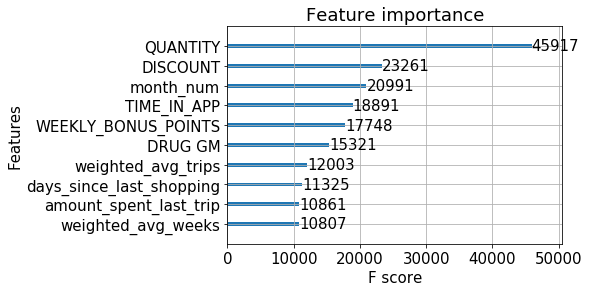

In [58]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(xgboost,max_num_features=10)


# 7.2. Polynomial Regression <a class="anchor" id="overfit"></a>

In [59]:
# tr = training_data.head(10000)
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
X = np.array(X)
polynomial_features = PolynomialFeatures(degree=1)
X = polynomial_features.fit_transform(X)
print(X.shape)

y = np.array(training_data['SALES_VALUE'].tolist())

# transforming the data to include another axis

# X = X[:, np.newaxis]
y = y[:, np.newaxis]

# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train_pr = X[:training_amount]
y_train_pr = y[:training_amount]
X_test_pr = X[training_amount:]
y_test_pr = y[training_amount:]

pr_model = LinearRegression()
pr_model.fit(X_train_pr, y_train_pr)

training_testing_metrics(X_train_pr, y_train_pr, X_test_pr, y_test_pr, pr_model)

(33063, 68)


,metrics,training,testing
0,mean absolute error,38.907483,41.678855
1,mean squared error,2793.711752,3220.658388
2,root mean squared error,52.855574,56.750845
3,mean absolute percentage error,844.263181,882.835594
4,r2,0.442736,0.386105


# 7.3. Random Forest <a class="anchor" id="decision_tree"></a>

In [60]:
rf = RandomForestRegressor(n_estimators=100, random_state = 42)

rf_pipeline = Pipeline([('regressor', rf)])
    
rf_model = rf_pipeline.fit(X_train, y_train)

training_testing_metrics(X_train, y_train, X_test, y_test, rf_model)

,metrics,training,testing
0,mean absolute error,11.251005,33.703370
1,mean squared error,250.225139,2133.718060
2,root mean squared error,15.818506,46.192186
3,mean absolute percentage error,203.818580,632.171050
4,r2,0.950087,0.593288


# 7.4. SVM <a class="anchor" id="svm"></a>

In [61]:
steps = [('scaler', StandardScaler()), ('SVM', SVR())]

svm_pipeline = Pipeline(steps)

svm_model =  svm_pipeline.fit(X_train, y_train)

training_testing_metrics(X_train, y_train, X_test, y_test, svm_model)

,metrics,training,testing
0,mean absolute error,40.655334,43.493926
1,mean squared error,3321.554314,3628.871848
2,root mean squared error,57.632927,60.240118
3,mean absolute percentage error,726.306835,787.659870
4,r2,0.337447,0.308295


# 7.5. Neural Network <a class="anchor" id="neural_network"></a>

In [62]:
steps = [('scaler', StandardScaler()), ('MLP', MLPRegressor(hidden_layer_sizes = (10), activation = 'relu', solver = 'sgd'))]

mlp_pipeline = Pipeline(steps)

mlp_model =  mlp_pipeline.fit(X_train, y_train)

training_testing_metrics(X_train, y_train, X_test, y_test, mlp_model)

,metrics,training,testing
0,mean absolute error,30.155992,34.150674
1,mean squared error,1745.471420,2236.860412
2,root mean squared error,41.778839,47.295459
3,mean absolute percentage error,529.298607,584.188067
4,r2,0.651829,0.573628
